# Mini Lab 1

Group 2 Members: Josh Mitchell, Adam Alidra, Ryan Herrin

## Requirements

- Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.

- Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

- Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

- Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

# Setup

In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn import metrics as mt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
%matplotlib inline
plt.style.use('ggplot')

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [2]:
# Read in data 

# NOTE: Data imported has been generated from the first lab and turned into two data sets 
# + One data set is the raw data minus columns that had no values in them 
# + The other data set is data that had a transformation applied to it 
raw_data_location = r'C:\Users\adalidra\OneDrive - Microsoft\AA_Top_Folder\Data Science Program\DS7331\Term Project\all_with_keyword_sum.csv'
transformed_data_location = r'C:\Users\adalidra\OneDrive - Microsoft\AA_Top_Folder\Data Science Program\DS7331\Term Project\transformed_data.csv'
delta_pca_location = r'C:\Users\adalidra\OneDrive - Microsoft\AA_Top_Folder\Data Science Program\DS7331\Term Project\delta_pca_data.csv'

raw_data_df = pd.read_csv(raw_data_location)
tf_data_df = pd.read_csv(transformed_data_location) # tf being shorthand for transformed
delta_pca = pd.read_csv(delta_pca_location)

In [3]:
# Create function to standardize how we modify incoming new csv datasets 
def is_obf_pipline(dataframe):
    pd_df = dataframe
    unused_columns = ['vt_harmless', 'vt_undetected', 'vt_malicious', 'vt_suspicious',
				      'avclass_name', 'obf_name', 'sha1', 'fpath']
    # Remove Duplicates
    pd_df.drop_duplicates('sha1', inplace=True)

    # Check to see if duplicate header is present. Remove if there is 
    if pd_df.at[0, 'sha1'] == 'sha1':
        pd_df = pd_df.iloc[1:] 

	# Remove unused columns 
    pd_df = pd_df.drop(columns=unused_columns)
    
    # Keep only the rows that are labled 1 or 3 in the "is_obf" column
    pd_df['is_obf'] = pd.to_numeric(pd_df['is_obf'], downcast='integer')
    pd_df.drop(pd_df.loc[pd_df['is_obf']==2].index, inplace=True)

    return(pd_df)

In [4]:
# Perform common transformation on raw data
raw_data_df = is_obf_pipline(raw_data_df)

# Logistic Regression Model and SVM Model

In [5]:
# Define common random seed value and sample test percentage size 
seed_value = 8675309 # if you know you know

### Split data into 80/20 Train Test

In [6]:
# helper function to split our data into train and test sets
def _split_data(dataframe, label_name, seed):
    '''Split the data from the dataframe into 80/20 test and returns the training data, 
    testing data, training/test features, train/test lables'''
    df_train, df_test = train_test_split(dataframe, test_size=.2, random_state=seed)
    df_train_features = df_train[df_train.columns[df_train.columns != label_name]].to_numpy() 
    df_test_features = df_test[df_test.columns[df_test.columns != label_name]].to_numpy()
    df_train_labels = df_train[df_train.columns[df_train.columns == label_name]].to_numpy().ravel()
    df_test_labels = df_test[df_test.columns[df_test.columns == label_name]].to_numpy().ravel()  

    return(df_train, df_test, df_train_features, df_test_features, df_train_labels, df_test_labels)

## Logistic Regression Model

LogisticRegression() Notes:

- @penalty: L1 = Lasso Regression, L2 = Ridge Regression "Squared magnitude"
- @C: Float value. "Smaller values specify stronger regularzation"
- @class_weight: Weights associated with classes in the form {class_label: weight}
- @max_iter: default was 100, but 150 was needed

In [7]:
# Function to generate logistic regression model
def  create_logistic_model(dataframe, label, seed=None):
    '''Function to create a linear regression model. When ran it will display the accuracy and confusion matrix of the model.
    @Params:
    - dataframe (pandasDataframe) : Dataframe Object
    - label (str) : name of the column that defines the label 
    - seed (optional) (int) : integer value for a seed
    @Returns: fitted LogisticRegression()
    '''
    # Create logistic regression model
    logreg_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear', max_iter=150) 
    # Data split
    df_train, df_test, df_train_features, df_test_features, df_train_labels, df_test_labels = _split_data(
        dataframe, label, seed
    )
    # Fit the model
    logreg_model.fit(df_train_features, df_train_labels)
    # Test out the model and create predictions 
    logreg_pred = logreg_model.predict(df_test_features)
    # get accuracy 
    logreg_accuracy = mt.accuracy_score(df_test_labels, logreg_pred)
    # Confusion Matrix 
    logreg_conf = mt.confusion_matrix(df_test_labels, logreg_pred)

    # Display results 
    print("Accuracy: ", logreg_accuracy)
    print("Confusion Matrix\n", logreg_conf)  

    return(logreg_model) 

In [8]:
print('Raw Data Model and Results')
raw_data_logreg_model = create_logistic_model(raw_data_df, 'is_obf', seed_value)

print('\n')

print('Transformed Model and Results')
tf_data_logreg_model = create_logistic_model(tf_data_df, 'is_obf', seed_value)

print('\n')

print('Delta PCA Model and Results')
delta_pca_logreg_model = create_logistic_model(delta_pca, 'is_obf', seed_value)

Raw Data Model and Results
Accuracy:  0.9601153291686689
Confusion Matrix
 [[ 613   27]
 [  56 1385]]


Transformed Model and Results
Accuracy:  0.9553099471407976
Confusion Matrix
 [[ 609   31]
 [  62 1379]]


Delta PCA Model and Results
Accuracy:  0.9452186448822681
Confusion Matrix
 [[ 631    9]
 [ 105 1336]]


Above are the results of running logistic regression models on our three different data sets. The data sets loaded included the original raw data set included 88 features across 40881 observations- in this data set we added a column, 'doc_keyword_totals', which aggregates columns 'doc_entropy' on as we illustrated in our exploratory data analysis. Next is the transformed data set, which includes 10405 observations and 49 features, and finally, the PCA data set, which includes 10406 observations, 2 Principal Components and a column depicting the 'is_obf' levels.

We run logistic regression given this study is based on a binary response, meaning, based on the observations within the inputted features of each data set, can we classify a record (a PowerShell script) to either be known unobfuscated or known NOT obfuscated. 

The confusion matrices, also known as error matrices, which assess the performance of classifying the variables under logistic regression have roughly similar results. The accuracy of the raw data model is slightly above the transformed and Delta PCA Model.Specifically, '613' observations are true positive (in other words accurately classified to be known unobfuscated), '1385' are true negative (accurately classified to be known NOT obfuscated), with a collective '85' observations to be either false negative (62) or false positive (31).

## Logistic Regression Weight Interpretation

In [9]:
def get_logreg_weights(dataframe, log_model, label_name, title=None, v=False):
    '''Prints the weights of each feature in the model and displays a graphic. Returns nothing. 
    @Params:
    - dataframe (PandasDataframe) : Dataframe used when creating the model
    - log_model (LogisticRegression) : Model returned from the create_logistic_model() function
    - label_name (string) : name of the lable column used to created the model
    - title (string) : Title of the bar graph
    - v (bool) : If true, prints the weights. If False, only prints chart
    '''
    # Create dataframe to send to bar grpah 
    logreg_tmp_df = dataframe[dataframe.columns[dataframe.columns != label_name]]
    logreg_wghts = pd.DataFrame(log_model.coef_[0], columns=['value'], index=logreg_tmp_df.columns)

    # display those that have a weight greater than .001
    logreg_wghts = logreg_wghts.loc[(logreg_wghts["value"] >= .001) | (logreg_wghts["value"] <= -.001)]

    # Plot / Display
    if title == None: 
        logreg_wghts.plot(kind='bar', title='Feature Weights')
    else:
        logreg_wghts.plot(kind='bar', title=title)
    plt.show()

    if v == True:
        # Display text Versions 
        # Get the weights for each variable 
        logreg_vars = zip(log_model.coef_.T, logreg_tmp_df)
        logreg_vars = sorted(logreg_vars)
        # Display Weights 
        print('\nFeature Weights\n---------------------')
        for coef, name in logreg_vars:
            print(name, 'weight: ', coef[0])

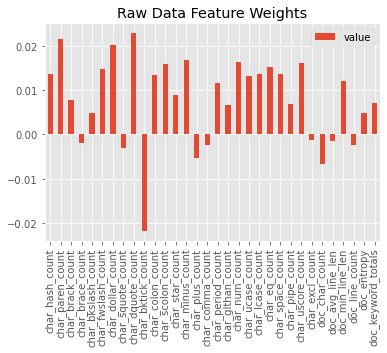

In [10]:
# Display Weights for Raw Data
get_logreg_weights(raw_data_df, raw_data_logreg_model, 'is_obf', title='Raw Data Feature Weights', v=False)

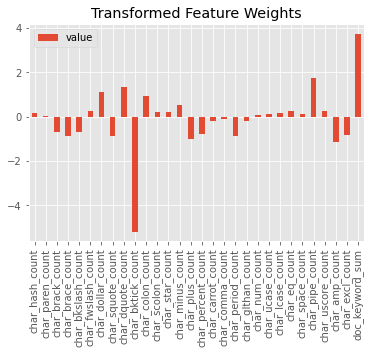

In [11]:
# Display Weights for Transformed Data
get_logreg_weights(tf_data_df, tf_data_logreg_model, 'is_obf', title='Transformed Feature Weights', v=False)

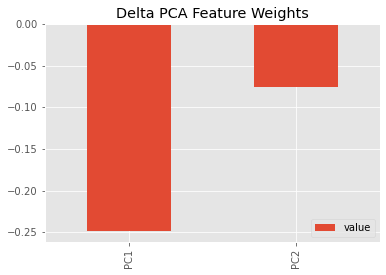

In [12]:
# Display Weights for PCA Delta Data
get_logreg_weights(delta_pca, delta_pca_logreg_model, 'is_obf', title='Delta PCA Feature Weights', v=False)

In the above section, we display weights 

# SVM Model

## Code for SVM Visualization

In [ ]:
# Code for visualiztion of SVM models 
'''
Referenced from:
https://chrisalbon.com/code/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/
'''
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

## SVM Model Creation

In [63]:
#SVM for Raw Data

def create_svm_model(dataframe, label, seed, svm_kernal='rbf', n_folds=5):
    '''Create SVM model. When ran it will display the accuracy and confusion matrix of the model. Returns SVM Model.
    @Params:
    - dataframe (pandasDataFrame) : Dataframe to run 
    - lable (string) : Name of column that's used as the lable
    - seed (optional) (int) : seed to keep random value the same 
    - svm_kernal : Refer to sklearn.svm for options. {linear, poly, rbf, sigmoid, precomputed}
    - n_folds (int) : number of k-folds that will be passed to the param selection pipeline. Default = 5
    @Returns: SVM Model
    '''
    # Data split
    df_train, df_test, df_train_features, df_test_features, df_train_labels, df_test_labels = _split_data(
        dataframe, label, seed
    )

    def svc_param_selection(X, y, n_folds):
        '''SVM Pipeline function to find the best parameters for SVM'''
        c = [0.001, 0.01, 0.1, 1, 10] # regularization is inversely proportional to C
        gammas = [0.001, 0.01, 0.1, 1] # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
        param_grid = {'C': c, 'gamma' : gammas}
        grid_search = GridSearchCV(svm.SVC(kernel=svm_kernal), param_grid, cv=n_folds)
        grid_search.fit(X, y)
        grid_search.best_params_

        return(grid_search.best_params_)

    # Get the best parameters for C and gamma using a pipeline
    best_params = svc_param_selection(df_train_features, df_train_labels, n_folds)
    svm_C = best_params['C']
    svm_gamma = best_params['gamma']

    print("Creating SVM using options ->  C: {}, kernel: {}, gamma: {}".format(
        svm_C, svm_kernal, svm_gamma)
        )

    # Model creation and testing
    svm_model = SVC(C=svm_C, kernel=svm_kernal, gamma=svm_gamma) # Create the SVM model object 
    svm_model.fit(df_train_features, df_train_labels) # Fit the model
    svm_y_hat = svm_model.predict(df_test_features) # Create predictions from the test data features
    # Get accuracy 
    svm_acc = mt.accuracy_score(df_test_labels, svm_y_hat)
    # Get confusion matrix 
    svm_conf = mt.confusion_matrix(df_test_labels, svm_y_hat)

    # Display results
    print("Accuracy: ", svm_acc)
    print("Confusion Matrix\n", svm_conf)

    return(svm_model)

### Transformed Data SVM

In [64]:
# Transformed data SVM model 
tf_svm_model = create_svm_model(tf_data_df, 'is_obf', seed_value, svm_kernal='rbf', n_folds=2)

Creating SVM using options ->  C: 10, kernel: rbf, gamma: 0.01
Accuracy:  0.9730898606439212
Confusion Matrix
 [[ 606   34]
 [  22 1419]]


### Raw Data SVM

In [69]:
# Raw data SVM model
raw_svm_model = create_svm_model(raw_data_df, 'is_obf', seed_value, svm_kernal='rbf', n_folds=2)

Creating SVM using options ->  C: 10, kernel: rbf, gamma: 0.001
Accuracy:  0.7169629985583854
Confusion Matrix
 [[  51  589]
 [   0 1441]]


### Delta_PCA SVM

In [68]:
# Delta PCA model 
delta_pca_svm_model = create_svm_model(delta_pca, 'is_obf', seed_value, svm_kernal='rbf', n_folds=2)

Creating SVM using options ->  C: 10, kernel: rbf, gamma: 0.01
Accuracy:  0.9553099471407976
Confusion Matrix
 [[ 618   22]
 [  71 1370]]


In [ ]:
pca = PCA(n_components = 8)
pca_fit = pca.fit(data.drop('is_obf', axis = 1))
X_pca_8 = pca_fit.transform(data.drop('is_obf', axis = 1))
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
df_pca_8 = pd.DataFrame(X_pca_8, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
df_pca_8['is_obf'] = raw_drop_df['is_obf'].values

In [ ]:
pca_svm_model = create_svm_model(df_pca_8, 'is_obf', seed_value, svm_kernal='rbf', n_folds=5)

- Since the PCA ony has two features we can actually visualize the SVM using the code below

In [ ]:
# Visualize the decision boundaries
# NOTE: This chart takes 25+ minutes to run
plot_decision_regions(
    delta_pca.loc[:, ('PC1', 'PC2')].to_numpy(), 
    delta_pca.loc[:, ('is_obf')].to_numpy(), 
    classifier=delta_pca_svm_model
    )
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## SVM Model 2

SVM model for the transformed data set

In [ ]:
# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=.01, C=1)
# Train the classifier
svm.fit(X_xor, y_xor)

# Visualize the decision boundaries
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Summary